Our goal is to tokenize this 20,479-character short story into individual words and special characters and then turn into embeddings for LLM training.

In [6]:
import os
import urllib.request

In [7]:
with open("the-verdict.txt", 'r', encoding='utf-8') as f:
    raw_text = f.read()

In [8]:
len(raw_text)

20479

Example

Traditional Tokenizer Library-> re

we refrain from lowercasing all the text because capitalization helps in seperating proper nouns and common nouns, understand sentence structure, and learn to generate text with proper
capitalization.

In [9]:
text= "hello world! Is this a-- test?"
import re
result= re.split(r'([,.:;?_!"()\']|--|\s)', text) # splitting on the punctuation
result= [ item.strip() for item in result if item.strip()] # removing empty strings/ whitespaces
print(result)

['hello', 'world', '!', 'Is', 'this', 'a', '--', 'test', '?']


removing the whitespaces is optional and depends on our application use case. reducing whitespace reduces memory consumption
* but keeping whitespaces is essential where the exact structure of text is required. like python code

In [10]:
# with our raw_text from verrdict.txt
result= re.split(r'([,.:;?_!"()\']|--|\s)', raw_text) # splitting on the punctuation
result= [ item.strip() for item in result if item.strip()] # removing empty strings/ whitespaces
preprocessed= result

In [11]:
len(preprocessed)

4690

Converting the tokens into TokenIDs

In [12]:
preprocessed[:10]

['I',
 'HAD',
 'always',
 'thought',
 'Jack',
 'Gisburn',
 'rather',
 'a',
 'cheap',
 'genius']

In [13]:
all_words= sorted(set(preprocessed))
vocab_size=len(all_words)

building the vocabulary

In [14]:
# string to integer mapping
vocab= {token: integer for integer, token in enumerate(all_words) }
print(vocab)

{'!': 0, '"': 1, "'": 2, '(': 3, ')': 4, ',': 5, '--': 6, '.': 7, ':': 8, ';': 9, '?': 10, 'A': 11, 'Ah': 12, 'Among': 13, 'And': 14, 'Are': 15, 'Arrt': 16, 'As': 17, 'At': 18, 'Be': 19, 'Begin': 20, 'Burlington': 21, 'But': 22, 'By': 23, 'Carlo': 24, 'Chicago': 25, 'Claude': 26, 'Come': 27, 'Croft': 28, 'Destroyed': 29, 'Devonshire': 30, 'Don': 31, 'Dubarry': 32, 'Emperors': 33, 'Florence': 34, 'For': 35, 'Gallery': 36, 'Gideon': 37, 'Gisburn': 38, 'Gisburns': 39, 'Grafton': 40, 'Greek': 41, 'Grindle': 42, 'Grindles': 43, 'HAD': 44, 'Had': 45, 'Hang': 46, 'Has': 47, 'He': 48, 'Her': 49, 'Hermia': 50, 'His': 51, 'How': 52, 'I': 53, 'If': 54, 'In': 55, 'It': 56, 'Jack': 57, 'Jove': 58, 'Just': 59, 'Lord': 60, 'Made': 61, 'Miss': 62, 'Money': 63, 'Monte': 64, 'Moon-dancers': 65, 'Mr': 66, 'Mrs': 67, 'My': 68, 'Never': 69, 'No': 70, 'Now': 71, 'Nutley': 72, 'Of': 73, 'Oh': 74, 'On': 75, 'Once': 76, 'Only': 77, 'Or': 78, 'Perhaps': 79, 'Poor': 80, 'Professional': 81, 'Renaissance': 82, 'Ri

* We build a vocabulary by tokenizing the entire text in a training dataset into individual tokens.
* These individual tokens are then sorted alphabetically, and duplicate tokens are removed.
* The unique tokens are then aggregated into a vocabulary that defines a mapping from each unique token to a unique integer value.
* The depicted vocabulary is purposefully small and contains no
punctuation or special characters for simplicity.

implementing a simple tokenizer 
* has encode(): convertes the tokens into token ids
* has decode(): converts the token ids back into tokens

In [15]:
# implementing a simpleTokenizer 
# the vocab consists of our entire word voacbulary
class SimpleTokenizerV1:
    def __init__(self, vocab):
        self.str_to_int= vocab
        self.int_to_str= {i:s for s,i in vocab.items()}
    
    # process input text into tokens
    def encode(self, text):
        preprocessed= re.split(r'([,.:;?_!"()\']|--|\s)', text)
        preprocessed= [item.strip() for item in preprocessed if item.strip()]
        ids= [self.str_to_int[s] for s in preprocessed]
        return ids
    
    def decode(self, ids):
        text= " ".join([self.int_to_str[i] for i in ids])
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)  # removing whitespaces before punctuation
        return text


implementing the tokenier now

In [16]:
tokenizer= SimpleTokenizerV1(vocab)

In [17]:
text = """"It's the last he painted, you know,"
 Mrs. Gisburn said with pardonable pride."""
ids= tokenizer.encode(text)
print(ids)

[1, 56, 2, 850, 988, 602, 533, 746, 5, 1126, 596, 5, 1, 67, 7, 38, 851, 1108, 754, 793, 7]


* if a particular word is not in our defined vocabulary then that will return in the key Error.

In [18]:
tokenizer.decode(ids)

'" It\' s the last he painted, you know," Mrs. Gisburn said with pardonable pride.'

### Adding Special Context Tokens

as we saw earlier that 

In [19]:
all_tokens= sorted(list(set(preprocessed)))
all_tokens.extend(["<|endoftext|>", "<|unk|>"]) 
vocab= {token: integer for integer, token in enumerate(all_tokens) }
for i, item in enumerate(list(vocab.items())[-5:]):
    print(item)

('younger', 1127)
('your', 1128)
('yourself', 1129)
('<|endoftext|>', 1130)
('<|unk|>', 1131)


In [20]:
# implementing a simpleTokenizer 
# the vocab consists of our entire word voacbulary
class SimpleTokenizerV1:
    def __init__(self, vocab):
        self.str_to_int= vocab
        self.int_to_str= {i:s for s,i in vocab.items()}
    
    # process input text into tokens
    def encode(self, text):
        preprocessed= re.split(r'([,.:;?_!"()\']|--|\s)', text)
        preprocessed= [item.strip() for item in preprocessed if item.strip()]
     
        # handle the unknown tokens and the end of text tokens
        preprocessed= [item if item in self.str_to_int else "<|unk|>" for item in preprocessed]
        ids= [self.str_to_int[s] for s in preprocessed ]
        return ids
    
    def decode(self, ids):
        text= " ".join([self.int_to_str[i] for i in ids])
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)  # removing whitespaces before punctuation
        return text


In [21]:
tokenizer= SimpleTokenizerV1(vocab)

In [22]:
ids=tokenizer.encode("Hello baby! How are you? Hope you are doing well. I am fine, thanks for asking.")
ids

[1131,
 1131,
 0,
 52,
 169,
 1126,
 10,
 1131,
 1126,
 169,
 357,
 1131,
 7,
 53,
 150,
 1131,
 5,
 1131,
 456,
 1131,
 7]

In [23]:
text= tokenizer.decode(ids)
text

'<|unk|> <|unk|>! How are you? <|unk|> you are doing <|unk|>. I am <|unk|>, <|unk|> for <|unk|>.'

### Byte Pair Encoding
* used in all versions of GPTs
* used in Meta LLMs too.
* used for handling the unknown words
* breaks down unknown tokens into subtokens
* The BPE tokenizer has a vocab of size-> 50,257


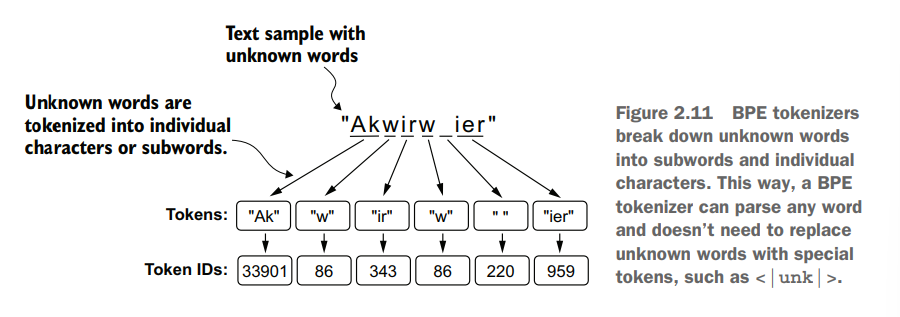

In [24]:
import tiktoken
tiktoken.__version__

'0.9.0'

In [25]:
tokenizer= tiktoken.get_encoding("gpt2")
ids=tokenizer.encode("ahdueheid")
text_decoded= tokenizer.decode(ids)
print(f"Encoded IDs: {ids}")
print(f"Decoded Text: {text_decoded}")

Encoded IDs: [993, 23301, 28420]
Decoded Text: ahdueheid


In [26]:
tokenizer= tiktoken.get_encoding("gpt2")

In [27]:
ids=tokenizer.encode("Hello baby! How are you? Hope you are doing well. I am fine, thanks for asking.")

In [28]:
tokenizer.decode(ids)

'Hello baby! How are you? Hope you are doing well. I am fine, thanks for asking.'

In [29]:
text= (
    "hey there do you like tea? <|endoftext|> in the sunlit terraces of the mountain city? dhwdbwsj"

)
ids=tokenizer.encode(text)
# error. you have to allow the special tokens

ValueError: Encountered text corresponding to disallowed special token '<|endoftext|>'.
If you want this text to be encoded as a special token, pass it to `allowed_special`, e.g. `allowed_special={'<|endoftext|>', ...}`.
If you want this text to be encoded as normal text, disable the check for this token by passing `disallowed_special=(enc.special_tokens_set - {'<|endoftext|>'})`.
To disable this check for all special tokens, pass `disallowed_special=()`.


In [30]:
ids= tokenizer.encode(text, allowed_special={"<|endoftext|>"})
ids

[20342,
 612,
 466,
 345,
 588,
 8887,
 30,
 220,
 50256,
 287,
 262,
 4252,
 18250,
 8812,
 2114,
 286,
 262,
 8598,
 1748,
 30,
 34590,
 86,
 9945,
 18504,
 73]

### Data Sampling with a Sliding Window

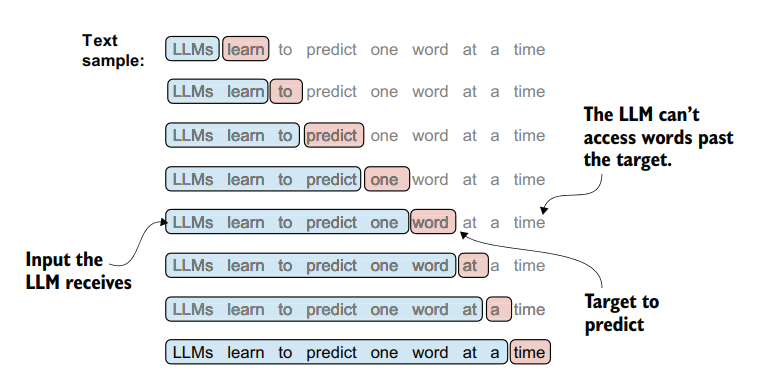

In [31]:
import tiktoken
with open("the-verdict.txt", 'r', encoding='utf-8') as f:
    raw_text= f.read()

tokenizer= tiktoken.get_encoding("gpt2")

# Data Sampling with a Sliding Window
enc_text= tokenizer.encode(raw_text)
print(len(enc_text))

5145


In [32]:
enc_text[:10]

[40, 367, 2885, 1464, 1807, 3619, 402, 271, 10899, 2138]

how to provide them efficiently to the LLMs. 

we will be passing them in chunks of 4 here. ex: `40, 367, 2885, 1464`

In [33]:
context_size=4
enc_sample= enc_text[50:]

# constructing the input and target sequences
x= enc_sample[:context_size]
y= enc_sample[1:context_size+1]

print(f"x: {x}")
print(f"y:       {y}")

x: [290, 4920, 2241, 287]
y:       [4920, 2241, 287, 257]


to better visualize this

In [34]:
for i in range(1, context_size+1):
    context= enc_sample[:i]
    desired= enc_sample[i]
    print(f"Context: {context}, ----->: {desired}")
    print(f"Context: {tokenizer.decode(context)}----->: {tokenizer.decode([desired])}")
    print("\n")

Context: [290], ----->: 4920
Context:  and----->:  established


Context: [290, 4920], ----->: 2241
Context:  and established----->:  himself


Context: [290, 4920, 2241], ----->: 287
Context:  and established himself----->:  in


Context: [290, 4920, 2241, 287], ----->: 257
Context:  and established himself in----->:  a




In [37]:
import torch
torch.__version__

'2.7.1+cpu'

understanding the dataloader pytorch class

In [38]:
# pytorch dataset class
# dataloader

# Train Set
X_train= torch.tensor([
    [-1.2, 3.1],
    [-0.9, 2.9],
    [-0.5, 2.6],
    [2.3, -1.1],
    [2.7, -1.5]
])
y_train= torch.tensor([0,0,0,1,1])

# test set
X_test= torch.tensor([
    [-0.8, 2.8],
    [2.6, -1.6],
])
y_test= torch.tensor([0,1])

pytorch provides 2 data primitives. 
* `torch.utils.data.DataLoader and torch.utils.data.Dataset`- 
* dataset stores the samples and the corresponding labels while dataloader wraps an iterable around the dataset class.

ch2/03_bonus_embedding/embeddingandlinearlayer

Doing the dataset loaders for Raw Text dataset

In [39]:
from torch.utils.data import Dataset, DataLoader
class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids= []
        self.target_ids= []

        # tokenize the text
        token_ids= tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # dont store trillions of tokens like this
        
        # create the sliding window
        for i in range(0, len(token_ids)-max_length, stride):
            input_chunk= token_ids[i:i+max_length]
            target_chunk= token_ids[i+1:i+max_length+1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))
    
    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

Building the dataloader

small batch sizes require less memory but can lead to a lot of noise in the model

In [41]:
def create_dataloader_v1(txt, batch_size=4, max_length=256, stride=128, shuffle= True, drop_last=True, num_workers=0):
    # these parameters can be overwritten 
    # batch_size: like how many samples are in our batch
    # max_length: the size of our context size [our box. at once]
    # stride: by how many places are we moving at once

    # initialize the tokenizer
    tokenizer= tiktoken.get_encoding("gpt2")

    # create the dataset
    dataset= GPTDatasetV1(txt, tokenizer, max_length, stride)

    # create the dataloader
    dataloader= DataLoader(
        dataset, 
        batch_size=batch_size,
        shuffle=shuffle,    
        drop_last=drop_last,
        num_workers=num_workers
    )
    return dataloader

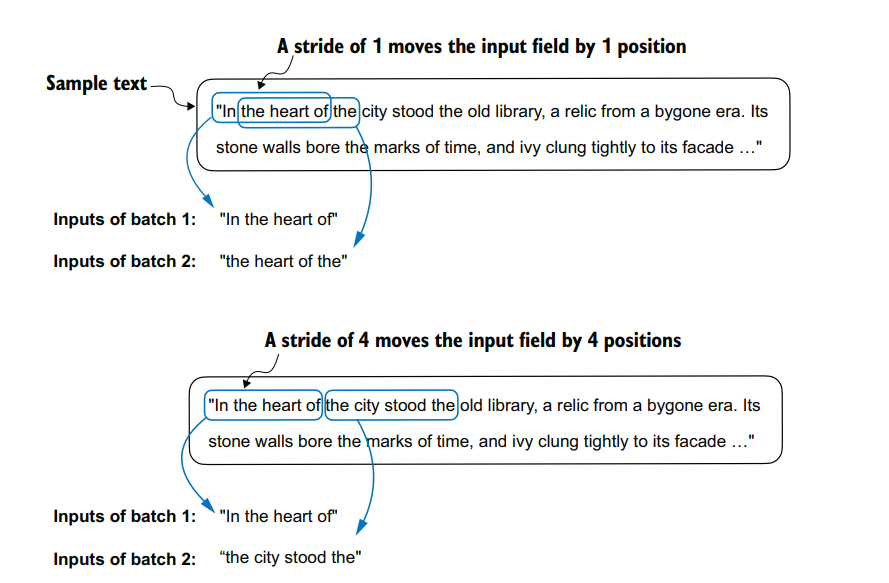

In [42]:
with open("the-verdict.txt", 'r', encoding='utf-8') as f:
    raw_text= f.read()

pass the raw_text into dataset and dataloader

In [43]:
dataloader=create_dataloader_v1(
    raw_text, batch_size=1, max_length=4, stride=1, shuffle=False
)
print(f"Number of batches: {len(dataloader)}")

data_iter= iter(dataloader)

# calling the __getitem__ method of the dataset class
first_batch= next(data_iter)

print(f"first_batch:{first_batch}")

Number of batches: 5141
first_batch:[tensor([[  40,  367, 2885, 1464]]), tensor([[ 367, 2885, 1464, 1807]])]


In [44]:
second_batch= next(data_iter)
print(f"second_batch:{second_batch}")

second_batch:[tensor([[ 367, 2885, 1464, 1807]]), tensor([[2885, 1464, 1807, 3619]])]


now as you can see that there is a huge amount of overlap in stride=1

this causes the llm to see some tokens many times-> overfitting

In [45]:
dataloader= create_dataloader_v1(raw_text, batch_size=8, max_length=4, stride=4, shuffle= False, drop_last=True, num_workers=0)
data_iter= iter(dataloader)
first_batch= next(data_iter)
print(f"first_batch:\n")
print(f"input_ids: {first_batch[0]}")
print(f"target_ids: {first_batch[1]}")

first_batch:

input_ids: tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])
target_ids: tensor([[  367,  2885,  1464,  1807],
        [ 3619,   402,   271, 10899],
        [ 2138,   257,  7026, 15632],
        [  438,  2016,   257,   922],
        [ 5891,  1576,   438,   568],
        [  340,   373,   645,  1049],
        [ 5975,   284,   502,   284],
        [ 3285,   326,    11,   287]])


lets create the token Embeddings

Example Embeddings

In [46]:
input_ids= torch.tensor([2,3,5,1])
vocab_size=6
output_dim=3

torch.manual_seed(123)
embedding_layer= torch.nn.Embedding(vocab_size, output_dim)
print(f"\ninput_ids: {input_ids}")
print(f"Embedding Layer Weights:{embedding_layer.weight}")



input_ids: tensor([2, 3, 5, 1])
Embedding Layer Weights:Parameter containing:
tensor([[ 0.3374, -0.1778, -0.1690],
        [ 0.9178,  1.5810,  1.3010],
        [ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096]], requires_grad=True)


create the embedding layer

READ ABOUT DIFFERENCE BETWEEN EMBEDDING LAYERS AND LINEAR LAYER

In [ ]:
embedding_layer(torch.tensor([3]))

tensor([[-0.4015,  0.9666, -1.1481]], grad_fn=<EmbeddingBackward0>)

In [ ]:
embedding_layer(torch.tensor([2]))

tensor([[ 1.2753, -0.2010, -0.1606]], grad_fn=<EmbeddingBackward0>)

In [ ]:
embedding_layer(torch.tensor([4]))

tensor([[-1.1589,  0.3255, -0.6315]], grad_fn=<EmbeddingBackward0>)

In [ ]:
embedding_layer(torch.tensor([2,3,5,1]))

tensor([[ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-2.8400, -0.7849, -1.4096],
        [ 0.9178,  1.5810,  1.3010]], grad_fn=<EmbeddingBackward0>)

### building token embeddings of our raw text

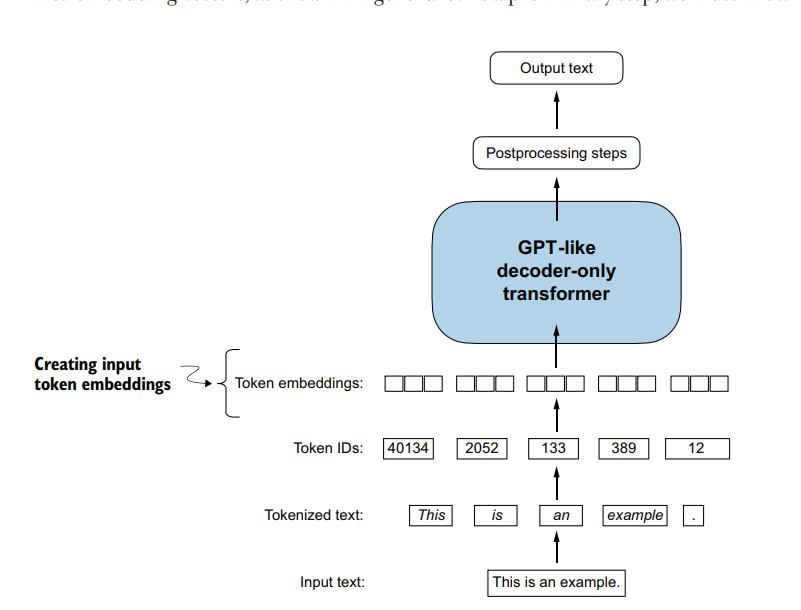

In [ ]:
tokenizer.n_vocab

50257

In [47]:
output_dim=3
embedding_layer= torch.nn.Embedding(tokenizer.n_vocab, output_dim)
embedding_layer.weight

Parameter containing:
tensor([[-2.1338,  1.0524, -0.3885],
        [-0.9343, -0.4991, -1.0867],
        [ 0.9624,  0.2492,  0.6266],
        ...,
        [ 0.9609, -1.3697,  0.1381],
        [-1.2365,  1.9319,  0.4730],
        [ 0.7365,  0.1316,  0.2379]], requires_grad=True)

### Adding word Positional Informations

why is positional encoding necessary?
* The embedding layer converts a token ID into the same vector
representation regardless of where it is located in the input sequence

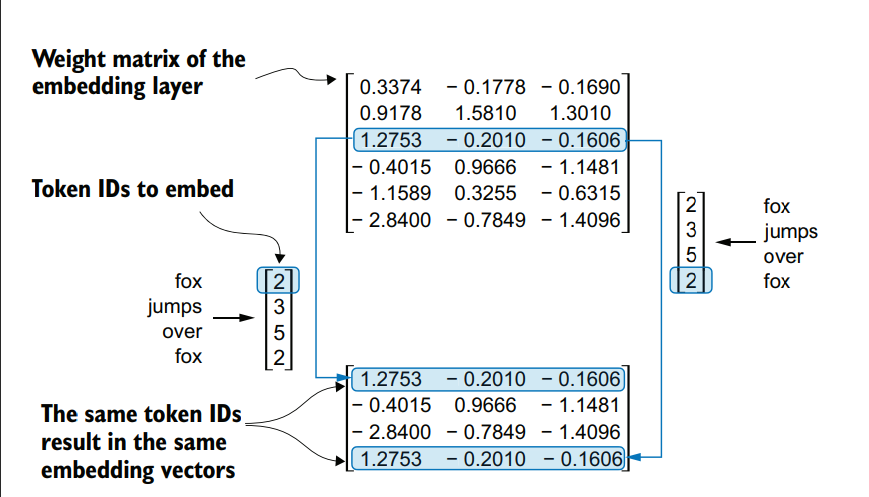

there are 2 categories if positional embeddings
* absolute positional embeddings- directly associated with the specific position of each token in the sequence. for each token, a unique embedding is added to the token's embeding.


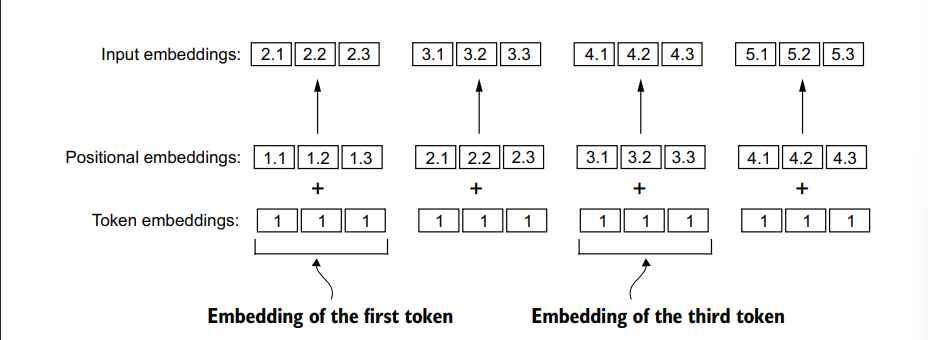

* relative positional embeddings- rather than the absolute position of each token, the focus lies on the relative distane or position between the tokens. 
    * this means that the LLMs learn "how far apart" rather than "at which exact position"

build dataset and dataloader

In [48]:
max_length=4
dataloader= create_dataloader_v1(
    raw_text, batch_size=8, max_length=max_length, stride=max_length, shuffle=False, drop_last=True
)
data_iter= iter(dataloader)
inputs, targets= next(data_iter) # get the first batch

In [49]:
print(f"Token Ids:\n", inputs)
print(f"Input shape:", inputs.shape)
print(f"Target Ids:\n", targets)

Token Ids:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])
Input shape: torch.Size([8, 4])
Target Ids:
 tensor([[  367,  2885,  1464,  1807],
        [ 3619,   402,   271, 10899],
        [ 2138,   257,  7026, 15632],
        [  438,  2016,   257,   922],
        [ 5891,  1576,   438,   568],
        [  340,   373,   645,  1049],
        [ 5975,   284,   502,   284],
        [ 3285,   326,    11,   287]])


build the embedding layer

In [50]:
vocab_size= tokenizer.n_vocab
output_dim=256

token_embedding_layer= torch.nn.Embedding(vocab_size, output_dim)

convert the token ids into embedding vectors

In [51]:
token_embeddings= token_embedding_layer(inputs)
token_embeddings.shape
# each input token id is converted into a vector of size output_dim
print(f"Token Embeddings of first batch:\n", token_embeddings[0])

Token Embeddings of first batch:
 tensor([[-0.7589, -0.0029,  0.4603,  ..., -0.1232, -0.0515, -1.7331],
        [-0.2983, -0.9563,  0.3115,  ..., -0.6631,  0.8920, -0.5409],
        [ 0.8074, -0.7397,  0.1875,  ..., -0.2645, -0.5492, -0.6099],
        [ 0.3620, -0.4569, -2.4207,  ..., -1.7047,  0.2635,  1.9265]],
       grad_fn=<SelectBackward0>)


adding positional information

using the absolute positional embedding approach

In [52]:
context_length= max_length
pos_embedding_layer= torch.nn.Embedding(context_length, output_dim)
print(f"Weights of pos_embedding_layer: {pos_embedding_layer.weight}")

Weights of pos_embedding_layer: Parameter containing:
tensor([[-0.7851,  1.5557,  1.1355,  ...,  0.5553, -0.6299,  0.2980],
        [ 0.8141,  0.9801, -0.9307,  ...,  2.2669, -1.0472, -0.0354],
        [-1.4536, -1.0188,  0.4802,  ...,  1.3324,  1.0717, -0.1117],
        [-0.4525,  0.1157,  1.9147,  ..., -0.4439, -0.8569, -0.6267]],
       requires_grad=True)


In [ ]:
# torch.arange(max_length)

tensor([0, 1, 2, 3])

In [53]:
pos_embedding_layer(torch.arange(max_length))

tensor([[-0.7851,  1.5557,  1.1355,  ...,  0.5553, -0.6299,  0.2980],
        [ 0.8141,  0.9801, -0.9307,  ...,  2.2669, -1.0472, -0.0354],
        [-1.4536, -1.0188,  0.4802,  ...,  1.3324,  1.0717, -0.1117],
        [-0.4525,  0.1157,  1.9147,  ..., -0.4439, -0.8569, -0.6267]],
       grad_fn=<EmbeddingBackward0>)

In [54]:
pos_embeddings= pos_embedding_layer(torch.arange(max_length))
print(f"Shape of Positional Embeddings of each batch:\n", pos_embeddings.shape)

Shape of Positional Embeddings of each batch:
 torch.Size([4, 256])


In [57]:
input_embeddings= token_embeddings+ pos_embeddings

print(f"Shape of Input Embeddings of each batch:\n", input_embeddings.shape)
print(f"Input Embeddings of first batch:\n", input_embeddings[0])
print(f"Token Embeddings of first batch:\n", token_embeddings[0])
print(f"Shape of Token Embeddings of first batch:\n", token_embeddings.shape)
print(f"Positional Embeddings of first batch:\n", pos_embeddings[0])
print(f"Shape of Positional Embeddings of first batch:\n", pos_embeddings.shape)

"""
the concept of broadcasting is used here. 
The positional embeddings are added to the token embeddings, 
and since the positional embeddings are of shape (max_length, output_dim), they are broadcasted across the batch dimension. 
This means that each token embedding in the batch gets its corresponding positional embedding added to it.
"""

Shape of Input Embeddings of each batch:
 torch.Size([8, 4, 256])
Input Embeddings of first batch:
 tensor([[-1.5439,  1.5527,  1.5959,  ...,  0.4321, -0.6814, -1.4351],
        [ 0.5158,  0.0238, -0.6193,  ...,  1.6039, -0.1552, -0.5763],
        [-0.6463, -1.7585,  0.6678,  ...,  1.0679,  0.5225, -0.7215],
        [-0.0905, -0.3412, -0.5061,  ..., -2.1486, -0.5934,  1.2998]],
       grad_fn=<SelectBackward0>)
Token Embeddings of first batch:
 tensor([[-0.7589, -0.0029,  0.4603,  ..., -0.1232, -0.0515, -1.7331],
        [-0.2983, -0.9563,  0.3115,  ..., -0.6631,  0.8920, -0.5409],
        [ 0.8074, -0.7397,  0.1875,  ..., -0.2645, -0.5492, -0.6099],
        [ 0.3620, -0.4569, -2.4207,  ..., -1.7047,  0.2635,  1.9265]],
       grad_fn=<SelectBackward0>)
Shape of Token Embeddings of first batch:
 torch.Size([8, 4, 256])
Positional Embeddings of first batch:
 tensor([-7.8508e-01,  1.5557e+00,  1.1355e+00, -1.1984e+00,  1.2151e+00,
         3.5090e-01,  1.1061e+00,  1.1307e+00,  1.8168e-0

'\nthe concept of broadcasting is used here. \nThe positional embeddings are added to the token embeddings, \nand since the positional embeddings are of shape (max_length, output_dim), they are broadcasted across the batch dimension. \nThis means that each token embedding in the batch gets its corresponding positional embedding added to it.\n'